In [1]:
import os

import pandas as pd
from keras.utils.image_dataset import paths_and_labels_to_dataset
from sklearn.model_selection import train_test_split

from __init__ import DATA_DIR
import dataset


df = dataset.make_database().explode("thumbs")
# Ignore Crystal Tokens
df.query("type_en != 'Crystal'", inplace=True)

# Ignore Boss Deck cards
df.query("rarity != 'B'", inplace=True)

# Ignore Full Art Cards
df.query(f"~thumbs.str.contains('_FL') and ~thumbs.str.contains('_2_')",
            inplace=True)

# Ignore Promo Cards, they tend to be Full Art
df.query(f"~thumbs.str.contains('_PR')", inplace=True)

# Ignore
df.query(f"~thumbs.str.contains('_premium')", inplace=True)

# Ignore by language
# df = df.query(f"~thumbs.str.contains('_eg')")  # English
df = df.query(f"~thumbs.str.contains('_fr')")  # French
df = df.query(f"~thumbs.str.contains('_es')")  # Spanish
df = df.query(f"~thumbs.str.contains('_it')")  # Italian
df = df.query(f"~thumbs.str.contains('_de')")  # German
df = df.query(f"~thumbs.str.contains('_jp')")  # Japanese

# WA: Bad Download/Image from server
df.query(f"thumbs not in ('8-080C_es.jpg', '11-138S_fr.jpg', '12-049H_fr_Premium.jpg', '13-106H_de.jpg')", inplace=True)

image_dir = os.path.abspath(os.path.join(DATA_DIR, "thumb"))
df.rename({"thumbs": "filename"}, axis=1, inplace=True)
df["filename"] = image_dir + os.sep + df["filename"]
df.drop(["images"], axis=1, inplace=True)
for lang in ("_es", "_de", "_fr", "_it"):
    df = df.loc[:,~df.columns.str.endswith(lang)]
# df.sort_values('code', ascending=False, inplace=True)

codes, uniques = df["mono"].factorize()
X_train, X_test, y_train, y_test = train_test_split(df['filename'],
                                                    codes,
                                                    test_size=0.33,
                                                    random_state=23,
                                                    shuffle=True,
                                                    stratify=df[["mono", "type_en"]])

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# df

In [2]:
import importlib

importlib.reload(dataset)

ds = paths_and_labels_to_dataset(
    image_paths=X_train.tolist(),
    image_size=(250, 179),
    num_channels=3,
    labels=y_train.tolist(),
    label_mode="binary",
    num_classes=len(uniques),
    interpolation="bilinear",
    # crop_to_aspect_ratio=crop_to_aspect_ratio,
)

ds = dataset.extendDataset(ds, seed=23, shuffle=False)
print(ds.cardinality())

tf.Tensor(121, shape=(), dtype=int64)


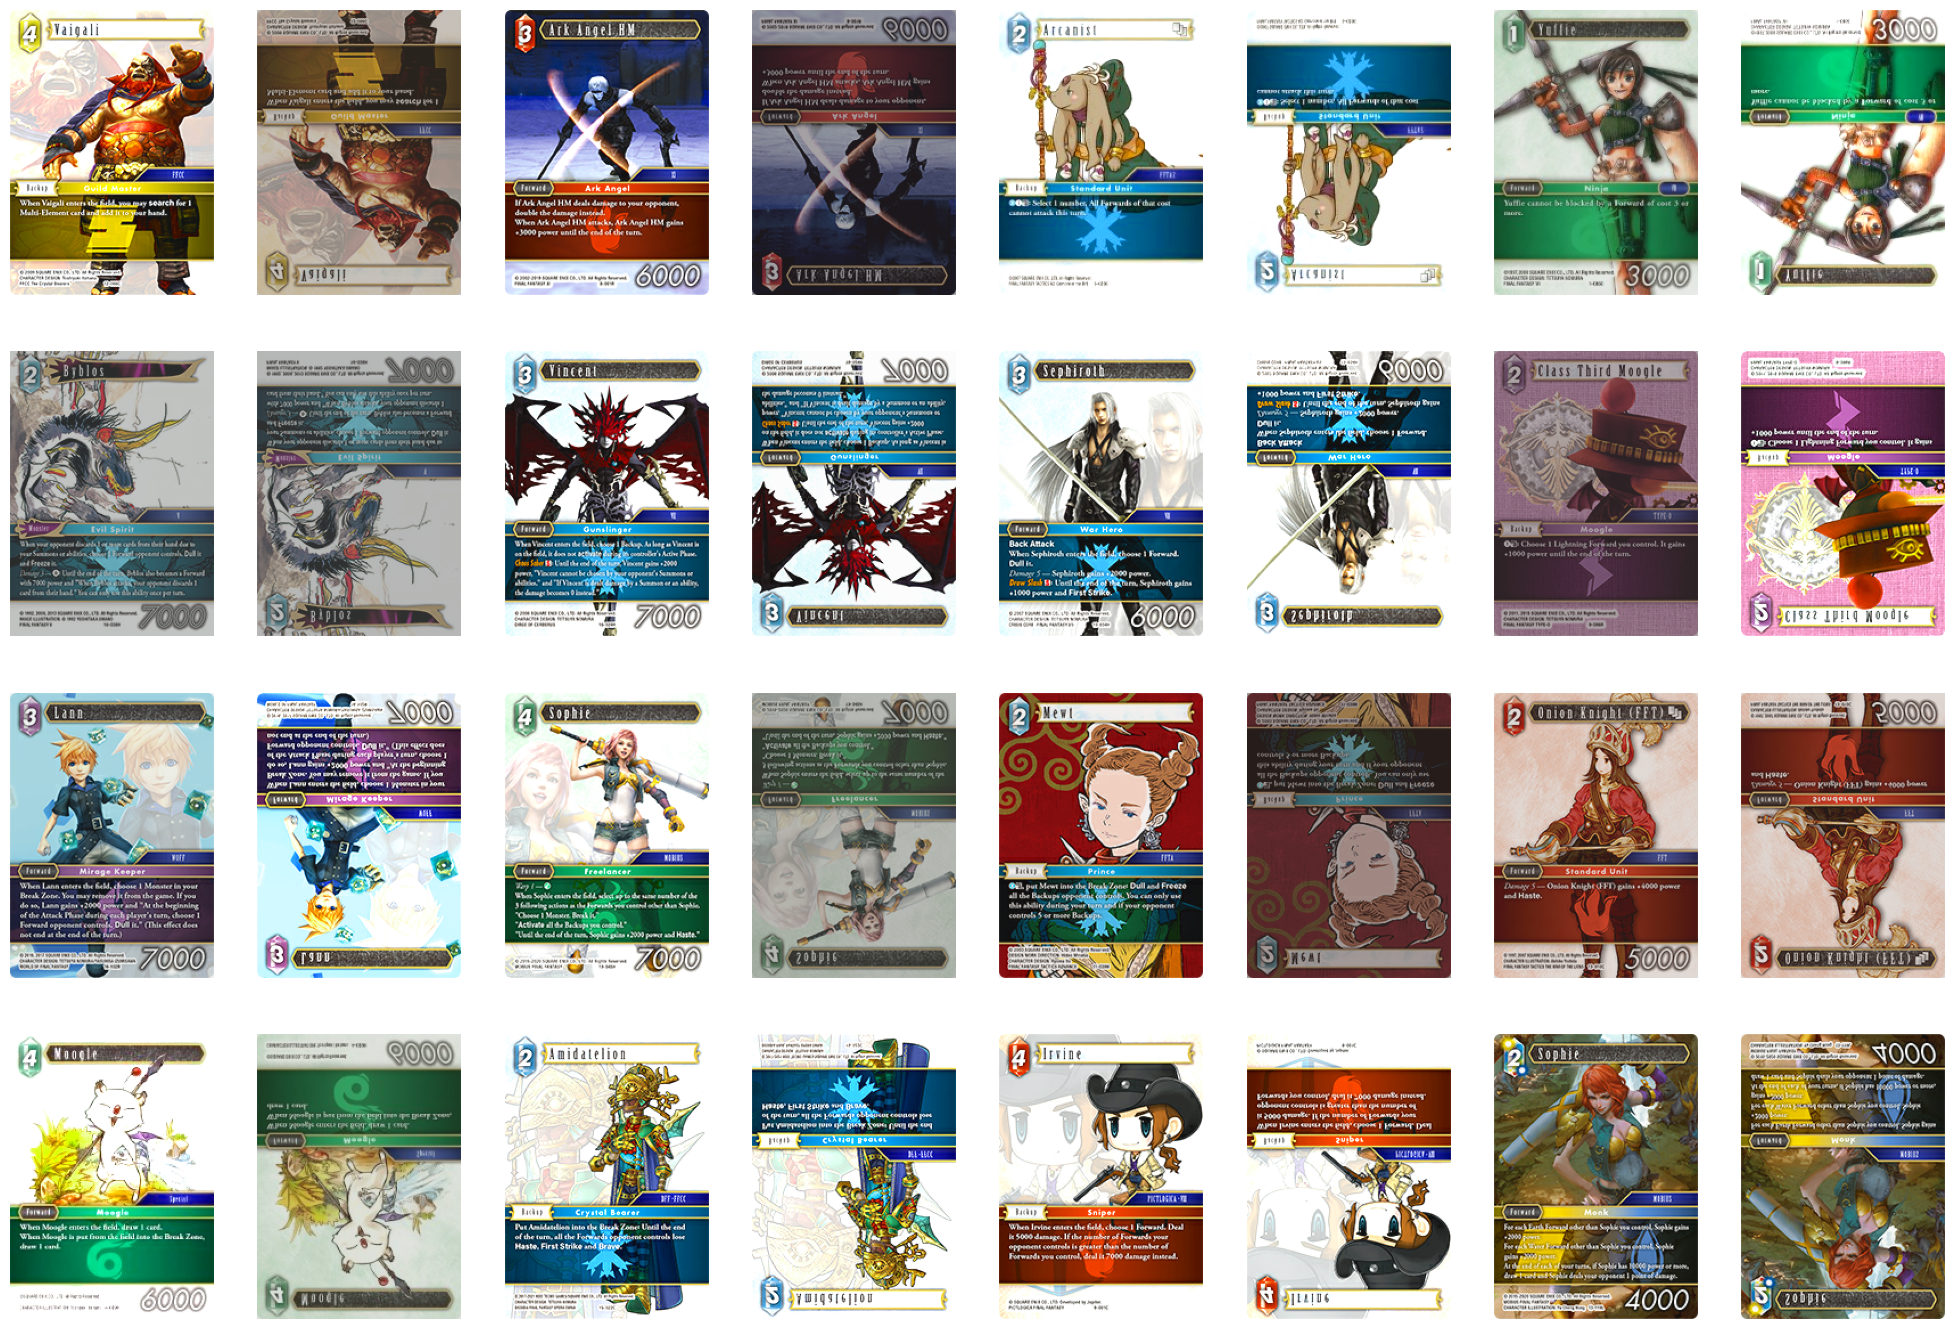

In [3]:
%matplotlib inline

from matplotlib import pyplot as plt

fig = plt.figure(figsize=(25, 17))

for images, labels in ds.take(1):
    for i, img in enumerate(images):
        fig.add_subplot(4, 8, i + 1)
        plt.imshow(img)
        plt.axis('off')
        # plt.title("Second")
    break

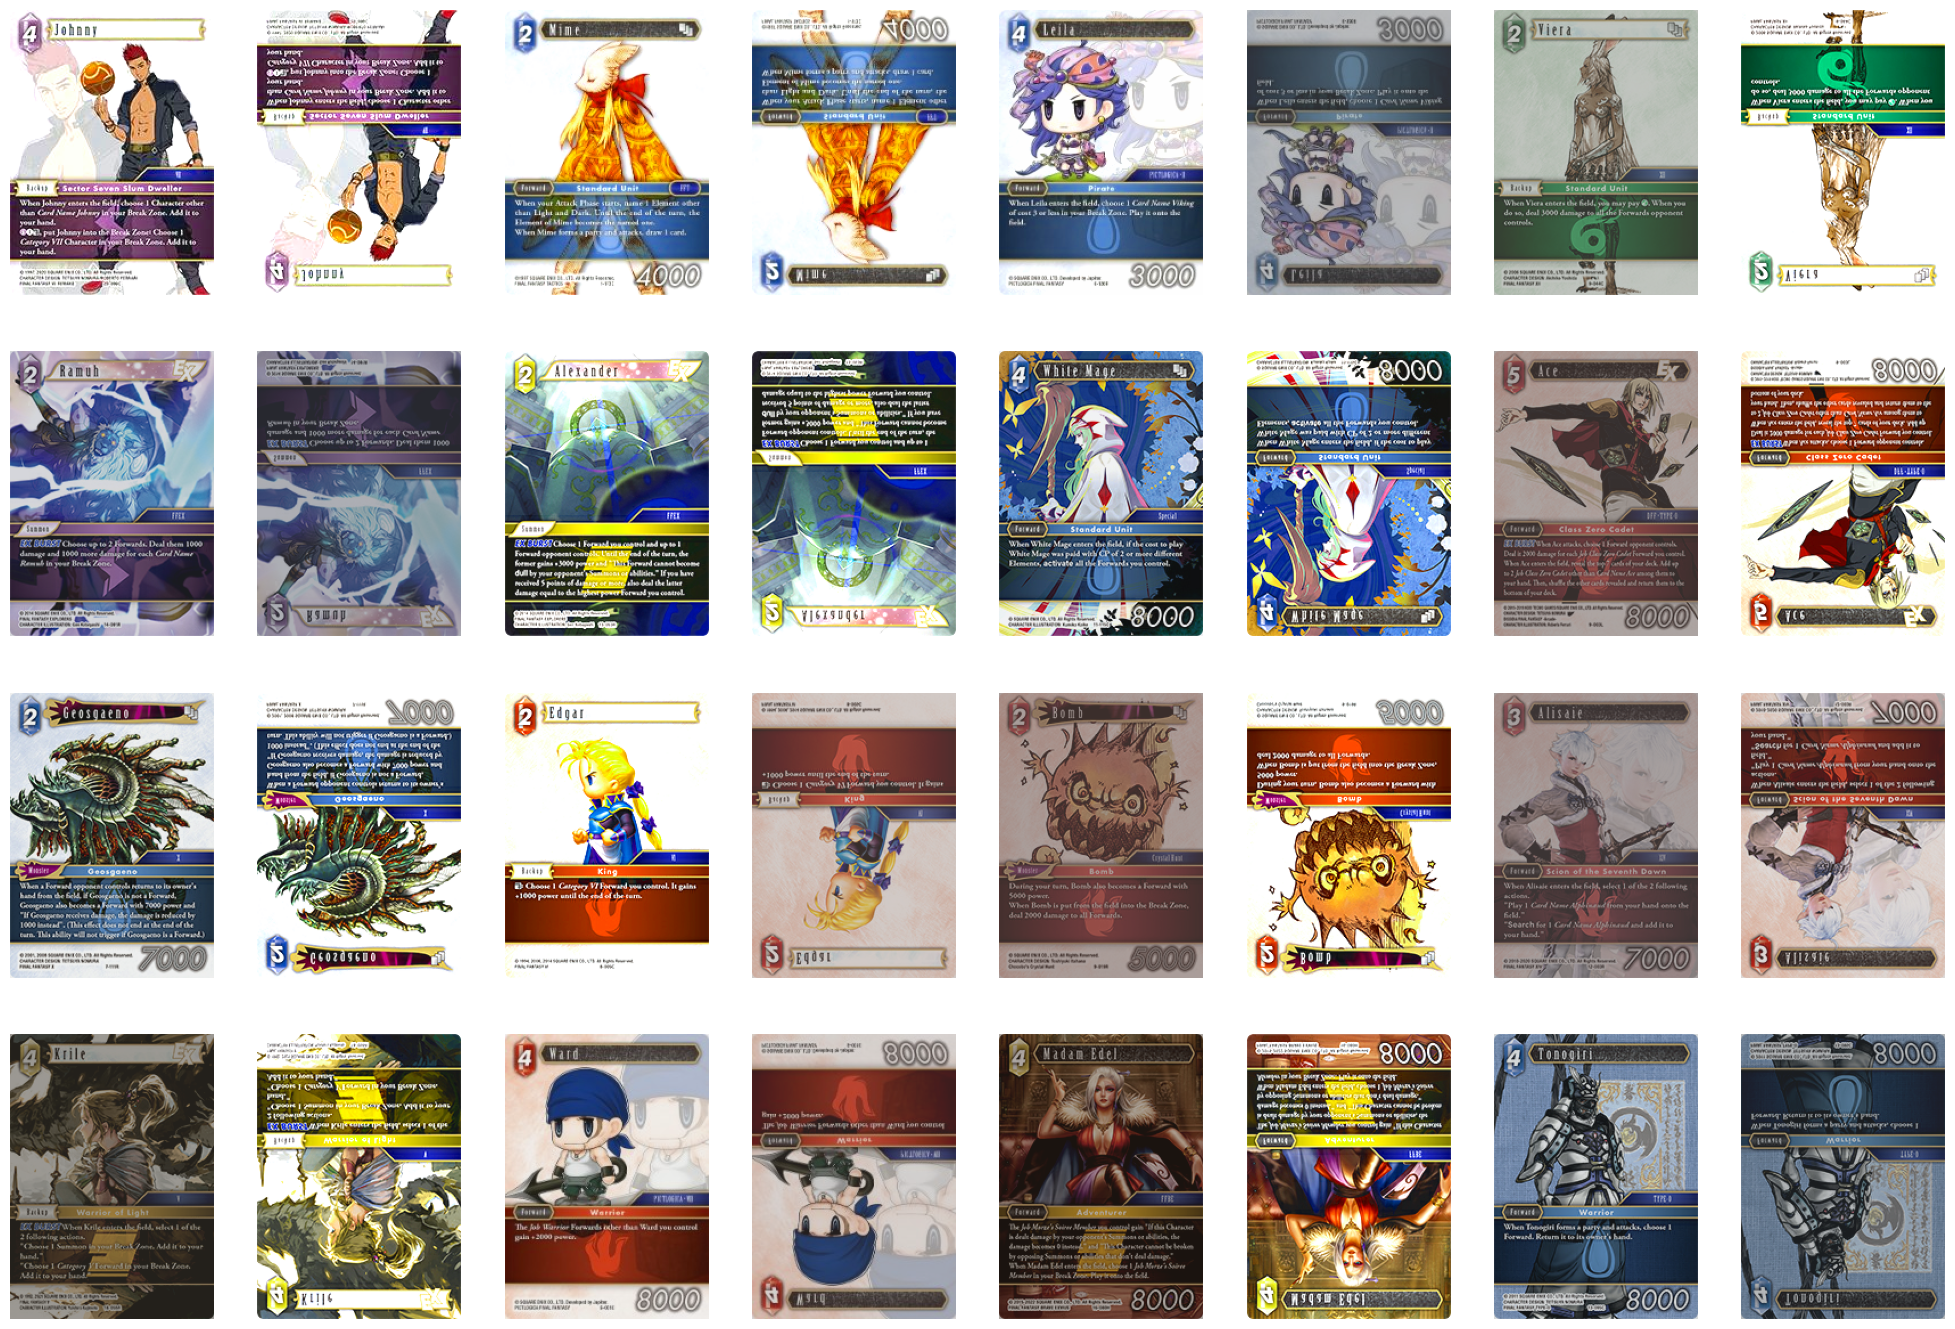

In [4]:
fig = plt.figure(figsize=(25, 17))

for images, labels in ds.skip(ds.cardinality() - 2).take(1):
    for i, img in enumerate(images):
        fig.add_subplot(4, 8, i + 1)
        plt.imshow(img)
        plt.axis('off')
        # plt.title("Second")
    break